In [2]:
pip install seaborn matplotlib


   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------ --------------------------- 2.4/7.8 MB 10.3 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/7.8 MB 10.3 MB/s eta 0:00:01
   --------------------------------- ------ 6.6/7.8 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------------- ------------------- 1.3/2.6 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 11.8 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/11.0 MB 10.7 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.0 MB 10.1 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.0 MB 7.7 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.0 MB 7.5 MB/s eta 0:00:01
   --------------------------------- ------ 9.2/11.0 MB 7.4 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.0 MB 6.6 MB/s eta 0:00:01
   -------------------------------------- - 10.5/11.0 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/44.5 MB ? eta -:--:--
    --------------------------------------- 0.8/44.5 MB 2.4 MB/s eta 0:00:19
    -----------

Combining training session data for trainer and user with ID

In [15]:
import pandas as pd

# Step 1: Load the CSV files
users_df = pd.read_csv('../DataEngineering/STAGING/staging_users.csv')
training_sessions_df = pd.read_csv('../DataEngineering/STAGING/staging_training_sessions.csv')

# Step 2: Merge the training sessions with the users on the trainer ID
# This will add user details for the trainer
merged_trainer_df = pd.merge(
    training_sessions_df,
    users_df,
    left_on='trainer',
    right_on='_id',
    how='left'
)

# Step 3: Rename columns for the trainer with a prefix
merged_trainer_df = merged_trainer_df.rename(
    columns={
        'username': 'username_trainer',
        'email': 'email_trainer',
        'role': 'role_trainer',
        'designation': 'designation_trainer'
    }
)

# Step 4: Merge the resulting dataframe with the users on participant_user ID
# This will add user details for each participant
final_combined_df = pd.merge(
    merged_trainer_df,
    users_df,
    left_on='participant_user',
    right_on='_id',
    how='left'
)

# Step 5: Rename columns for the participants with a prefix
final_combined_df = final_combined_df.rename(
    columns={
        'username': 'username_participant',
        'email': 'email_participant',
        'role': 'role_participant',
        'designation': 'designation_participant'
    }
)

# Step 6: Drop unnecessary columns (if any)
# You can modify this list based on your needs
final_combined_df = final_combined_df.drop(
    columns=['_id_x', '_id_y','trainer','participant_user','password_x','password_y'],  # Dropping user ID columns from both merges
    errors='ignore'
)

# Step 7: Save the combined dataframe to a new CSV file
final_combined_df.to_csv('combined_training_sessions.csv', index=False)

print("Combined CSV file created successfully.")


Combined CSV file created successfully.


In [30]:
import pandas as pd

# Step 1: Load the data
df = pd.read_csv('combined_training_sessions.csv')

# Step 2: Basic data exploration
print("Data Info:\n", df.info())
print("Missing Values:\n", df.isnull().sum())
print("Basic Statistics:\n", df.describe())

# Step 3: Parse dates and calculate training duration
df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])
df['training_duration_days'] = (df['endDate'] - df['startDate']).dt.days

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   training_code                1612 non-null   object
 1   status                       1612 non-null   object
 2   startDate                    1612 non-null   object
 3   endDate                      1612 non-null   object
 4   participant_hackerRankScore  1612 non-null   int64 
 5   participant_assessmentScore  1612 non-null   int64 
 6   participant_performance      1612 non-null   int64 
 7   participant_communication    1612 non-null   int64 
 8   participant_remarks          1612 non-null   object
 9   username_trainer             1612 non-null   object
 10  email_trainer                1612 non-null   object
 11  role_trainer                 1612 non-null   object
 12  designation_trainer          1612 non-null   object
 13  username_participant         1612

Feature Engineering

In [42]:
import pandas as pd

# Load the dataset
df = pd.read_csv('combined_training_sessions.csv')

# Step 4: Participant score analysis
score_cols = ['participant_hackerRankScore', 'participant_assessmentScore',
              'participant_performance', 'participant_communication']

# Summary statistics
print("\nScore Statistics:\n", df[score_cols].describe())

# Step 5: Feature Engineering - Aggregate Performance Metrics
# Average score metric for each participant
df['mean_participant_score'] = df[score_cols].mean(axis=1)

# Flag high performers (custom threshold for promotion)
df['promotion'] = (df['mean_participant_score'] > 7).astype(int)

# Retention flag based on mean score threshold
df['retention'] = (df['mean_participant_score'] > 4).astype(int)

# Step 6: Categorical Encoding of Status
df['status_pending'] = (df['status'] == 'pending').astype(int)
df['status_ongoing'] = (df['status'] == 'ongoing').astype(int)
df['status_completed'] = (df['status'] == 'completed').astype(int)

# Step 7: Encode training_code by category
training_code_map = {
    'FS': 'Full Stack Development',
    'DS': 'Data Science',
    'DE': 'Data Engineering',
    'UI': 'UI/UX',
    'ST': 'Software Testing'
}

# Extract the prefix (first two characters) and map to the category
df['training_category'] = df['training_code'].str[:2].map(training_code_map)


# Step 8: Explore Trainer and Participant Roles
print("\nRole Distribution for Trainer:\n", df['role_trainer'].value_counts())
print("\nRole Distribution for Participant:\n",
      df['role_participant'].value_counts())

target_columns = ['designation_trainer', 'designation_participant', 'training_category']
target_vars = ['promotion', 'retention']

# Step 2: Target encoding based on mean of `promotion` and `retention`
for col in target_columns:
    for target in target_vars:
        # Calculate mean target variable by group and assign to a new column
        df[f'{col}_{target}_encoded'] = df.groupby(col)[target].transform('mean')

# Drop the original categorical columns if desired
df.drop(columns=target_columns, inplace=True)


# Step 9: Drop `startDate` and `endDate` columns
df.drop(columns=['startDate', 'endDate', 'participant_hackerRankScore', 'participant_assessmentScore',
        'participant_performance', 'participant_communication', 'participant_remarks', 'email_trainer',
        'role_trainer', 'email_participant', 'role_participant', 'username_trainer', 'username_participant', 'training_code','status'], inplace=True)

# Step 10: Save the modified dataset
df.to_csv('enriched_training_sessions.csv', index=False)
print("Enriched dataset saved.")


Score Statistics:
        participant_hackerRankScore  participant_assessmentScore  \
count                  1612.000000                  1612.000000   
mean                      4.885856                     4.962779   
std                       2.931559                     2.862433   
min                       0.000000                     0.000000   
25%                       2.000000                     3.000000   
50%                       5.000000                     5.000000   
75%                       7.000000                     7.000000   
max                      10.000000                    10.000000   

       participant_performance  participant_communication  
count              1612.000000                1612.000000  
mean                  4.976427                   5.037841  
std                   2.894922                   2.859930  
min                   0.000000                   0.000000  
25%                   2.000000                   3.000000  
50%             

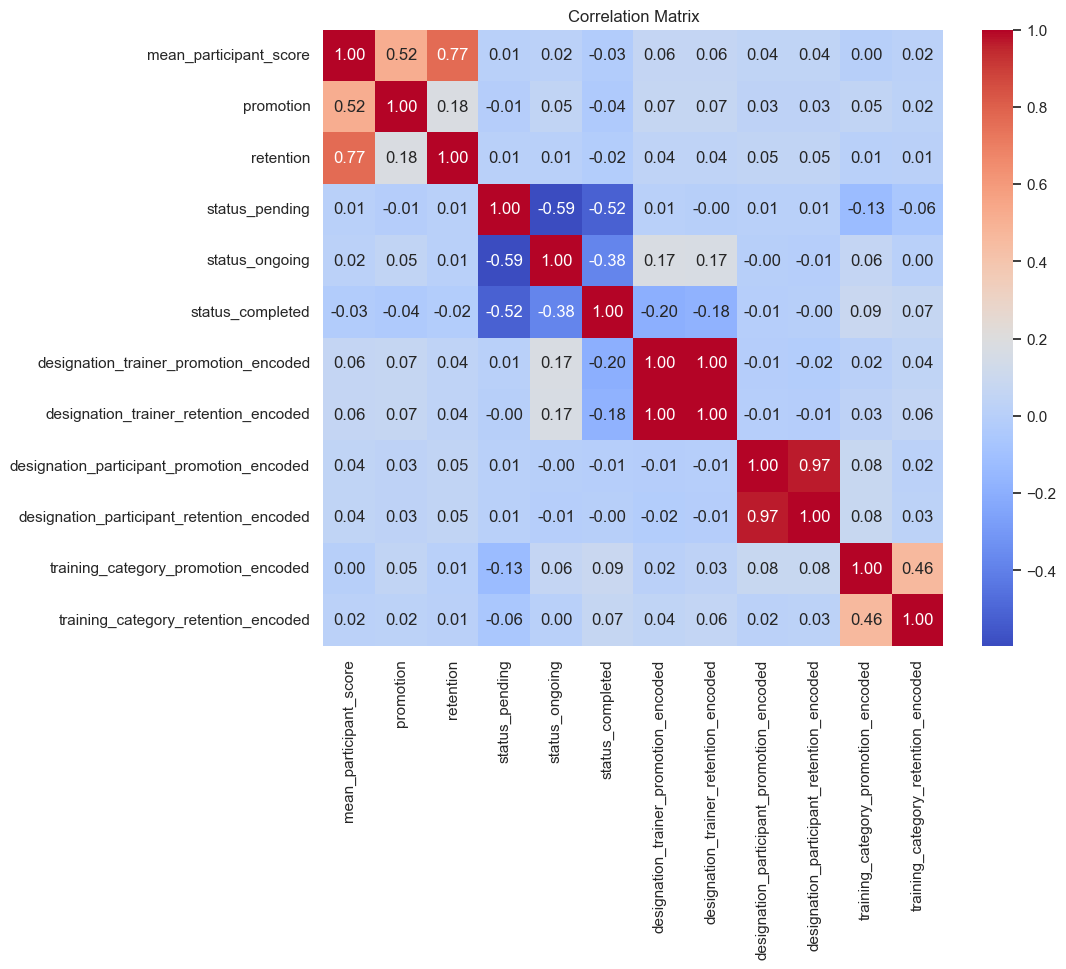

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('enriched_training_sessions.csv')

# Calculate the correlation matrix for numerical columns
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()